## AL model sensitivity analysis

Reads in PN firing rates in response to odor panel stored from runs of the model with varied sensitivity parameters ($a_{ORN}$, $a_{iLN}$, $a_{eLN}$, $a_{PN}$) and creates supplementary figure displaying firing rates + cohen's d from baseline un-maniplated run of the model.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.spatial.distance import pdist
from matplotlib.colors import LogNorm
from scipy.stats import spearmanr
from numpy.linalg import norm

In [2]:
import os
import sys
project_dir = '../../'
sys.path.append(project_dir)

from utils.data_utils import make_df_AL_activity_long, make_orn_upn_frs, make_glomerular_odor_responses
from utils.plot_utils import set_font_sizes
from utils.plot_utils_EXTRA import plot_sim_raster, plot_mini_raster
from utils.odor_utils import load_door_data

set_font_sizes()

In [3]:
from utils.data_utils import get_AL_activity_dfs, \
    make_d_neur_inputs, make_orn_upn_frs, make_glomerular_odor_responses, make_df_AL_activity_long
from utils.make_output_figures import plot_sim_spikes2, plot_neur_I_contribs, plot_psths, \
    plot_synapse_scale_hmap

In [4]:
from datetime import datetime
import pickle
import re

## load single-param and multi-param manipulated runs

In [5]:
df_neur_ids = pd.read_csv('../../connectomics/hemibrain_v1_2/df_neur_ids.csv', index_col=0)

In [6]:
d_res_sensitivity_base = pickle.load(open('model_run_neuron_firing_rates/sensitivity_base_df_AL_activitys.p', 'rb'))
d_res_sensitivity_0p25 = pickle.load(open('model_run_neuron_firing_rates/sensitivity_0p25single_param_df_AL_activitys.p', 'rb'))
d_res_sensitivity_0p5 = pickle.load(open('model_run_neuron_firing_rates/sensitivity_0p5single_param_df_AL_activitys.p', 'rb'))
d_res_sensitivity_0p75 = pickle.load(open('model_run_neuron_firing_rates/sensitivity_0p75single_param_df_AL_activitys.p', 'rb'))
d_res_multi_0p5sd = pickle.load(open('model_run_neuron_firing_rates/multiparam_0p5_df_AL_activitys.p', 'rb'))

In [7]:
df_AL_activity = d_res_sensitivity_base['base']

In [8]:
run_names_0p25 = list(d_res_sensitivity_0p25.keys())
run_names_0p5 = list(d_res_sensitivity_0p5.keys())
run_names_0p75 = list(d_res_sensitivity_0p75.keys())
run_names_multi = list(d_res_multi_0p5sd.keys())

In [9]:
d_all_runs = {**d_res_sensitivity_base, **d_res_sensitivity_0p25, **d_res_sensitivity_0p5, **d_res_sensitivity_0p75}
d_res_multi = {**{r: d_res_multi_0p5sd[r]['df_AL_activity'] for r in d_res_multi_0p5sd.keys()}}
d_all_runs = {**d_all_runs, **d_res_multi}

In [10]:
mac_odors = np.array(['3-octanol',
                        '1-hexanol',
                        'ethyl lactate',
                        #'citronella',
                        '2-heptanone',
                        '1-pentanol',
                        'ethanol',
                        'geranyl acetate',
                        'hexyl acetate',
                        '4-methylcyclohexanol',
                        'pentyl acetate',
                        '1-butanol'
                        ])
odor_names = mac_odors

## store all firing rates

In [11]:
# plot Bhandawat version
bhand_gloms = ['DL1', 'DM1', 'DM2', 'DM3', 'DM4', 'VA2']
df_neur_ids_bhand  = df_neur_ids.copy()[((df_neur_ids.altype == 'ORN') & (df_neur_ids.glom.isin(bhand_gloms))) | 
          (df_neur_ids.altype == 'LN') | 
           ((df_neur_ids.altype == 'uPN') & (df_neur_ids.glom.isin(bhand_gloms))) |
           (df_neur_ids.altype == 'mPN')
          ]

d_full_res = {}

for runtag in d_all_runs.keys():
      
    df_AL_activity = d_all_runs[runtag]
    
    df_AL_activity_bhand  = df_AL_activity.copy()[((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
          (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
           ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
           (df_AL_activity.neur_type == 'mPN')
          ]
    df_AL_activity_long_bhand = make_df_AL_activity_long(df_AL_activity_bhand)
    df_orn_frs_bhand, df_upn_frs_bhand = make_orn_upn_frs(df_AL_activity_bhand, 
                                                          odor_names, 
                                                          df_neur_ids_bhand.reset_index(),
                                                          sub_pre=True, olf_only=True)
    df_orn_glom_onoff_bhand, df_upn_glom_onoff_bhand = \
        make_glomerular_odor_responses(df_orn_frs_bhand, df_upn_frs_bhand, df_AL_activity_bhand)

    
    ## ORN and PN firing rates
    df_orn_frs_allglom_ON, df_upn_frs_allglom_ON = make_orn_upn_frs(df_AL_activity, odor_names, df_neur_ids.reset_index(),
                                                  sub_pre=False, olf_only=True)
    
    
    
    ### BHANDAWAT VERSION
    df_AL_activity_bhand  = df_AL_activity.copy()[
        ((df_AL_activity.neur_type == 'ORN') & (df_AL_activity.glom.isin(bhand_gloms))) | 
        (df_AL_activity.neur_type.isin(['iLN', 'eLN'])) | 
        ((df_AL_activity.neur_type == 'uPN') & (df_AL_activity.glom.isin(bhand_gloms))) |
        (df_AL_activity.neur_type == 'mPN')
    ]


    ## ORN and PN firing rates
    df_AL_activity_long_bhand = make_df_AL_activity_long(df_AL_activity_bhand)
    df_orn_frs_bhand_ONOFF, df_upn_frs_bhand_ONOFF = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                                  sub_pre=True, olf_only=True)
    df_orn_frs_bhand_ON, df_upn_frs_bhand_ON = make_orn_upn_frs(df_AL_activity_bhand, odor_names, df_neur_ids_bhand.reset_index(),
                                                  sub_pre=False, olf_only=True)
    
    d_full_res[runtag] = {'df_AL_activity': df_AL_activity,
                          'df_orn_frs_allglom_ON': df_orn_frs_allglom_ON,
                            'df_upn_frs_allglom_ON': df_upn_frs_allglom_ON,
                            'df_orn_frs_bhand_ON': df_orn_frs_bhand_ON,
                            'df_upn_frs_bhand_ON': df_upn_frs_bhand_ON,
                            'df_AL_activity_bhand': df_AL_activity_bhand
                           }

In [12]:
d_color = {
    'ORN': '#ffc951',
    'PN': '#8621f1',
    'iLN': 'turquoise',#'#39b54a',#'blue',
    'eLN': 'red',#39b54a',#'red',
    'uPN': '#8621f1',
    'mPN': 'grey',
    'LN': '#39b54a',
    'glom': '#a4c0e6'
}

## single-param manipulation

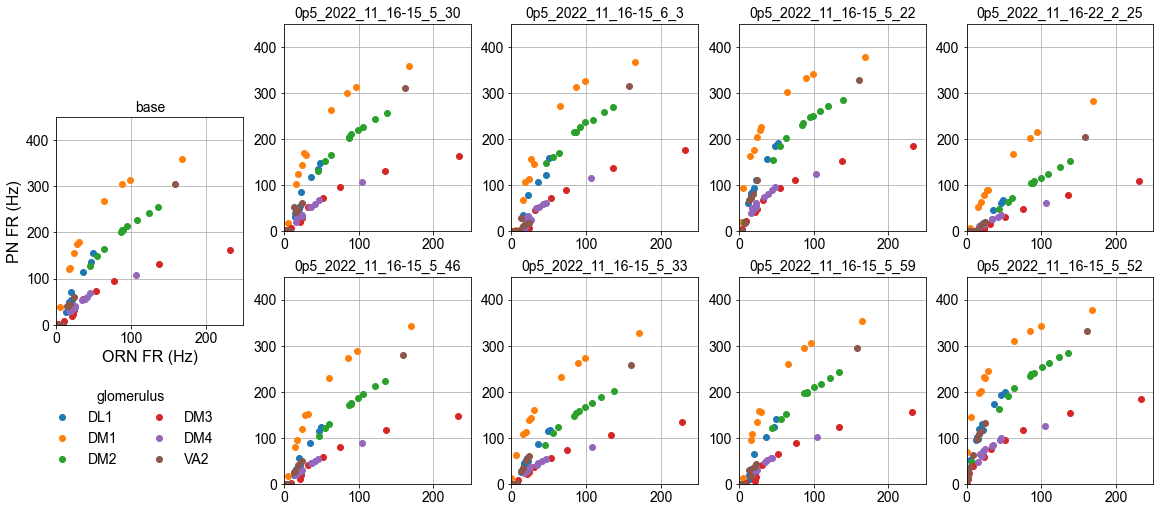

In [13]:
ax_names = ['base', 'ORN x4/3', 'ORN x3/4', 'eLN x4/3', 'eLN x3/4', 'iLN x4/3', 'iLN x3/4', 'PN x4/3', 'PN x3/4']
#ax_names = ['base', 'ORN x2', 'ORN x1/2', 'eLN x2', 'eLN x1/2', 'iLN x2', 'iLN x1/2', 'PN x2', 'PN x1/2']
ax_names = ['base', 'ORN x4', 'ORN x1/4', 'eLN x4', 'eLN x1/4', 'iLN x4', 'iLN x1/4', 'PN x4', 'PN x1/4']

ax_names = ['base'] + run_names_multi[:8]
def plot_PN_vs_ORN_fr(ax, orn_table, pn_table, gloms):
    for g in gloms:
        ax.plot(orn_table.loc[g], pn_table.loc[g], 'o', label=g)
    return None
 
fig = plt.figure(constrained_layout=True, figsize=(16,7), facecolor='w')
gs = GridSpec(7, 5, figure=fig)

ax_base = fig.add_subplot(gs[2:5, 0])

ax_orn_up = fig.add_subplot(gs[:3, 1], sharex=ax_base, sharey=ax_base)
ax_orn_down = fig.add_subplot(gs[4:, 1], sharex=ax_base, sharey=ax_base)
ax_eln_up = fig.add_subplot(gs[:3, 2], sharex=ax_base, sharey=ax_base)
ax_eln_down = fig.add_subplot(gs[4:, 2], sharex=ax_base, sharey=ax_base)
ax_iln_up = fig.add_subplot(gs[:3, 3], sharex=ax_base, sharey=ax_base)
ax_iln_down = fig.add_subplot(gs[4:, 3], sharex=ax_base, sharey=ax_base)
ax_pn_up = fig.add_subplot(gs[:3, 4], sharex=ax_base, sharey=ax_base)
ax_pn_down = fig.add_subplot(gs[4:, 4], sharex=ax_base, sharey=ax_base)

ax_list = [ax_base, ax_orn_up, ax_orn_down, ax_eln_up, ax_eln_down, ax_iln_up, ax_iln_down, ax_pn_up, ax_pn_down]


for ia in range(len(ax_list)):
    cur_ax_name = ax_names[ia]
    cur_ax = ax_list[ia]
    
    cur_ax.grid()
    
    df_orn_frs_bhand_ON = d_full_res[cur_ax_name]['df_orn_frs_bhand_ON']
    df_upn_frs_bhand_ON = d_full_res[cur_ax_name]['df_upn_frs_bhand_ON']
    df_AL_activity_bhand = d_full_res[cur_ax_name]['df_AL_activity_bhand']
    
    df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON = \
        make_glomerular_odor_responses(df_orn_frs_bhand_ON, df_upn_frs_bhand_ON, df_AL_activity_bhand)
    
    plot_PN_vs_ORN_fr(cur_ax, df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON, bhand_gloms)
    
    cur_ax.set_title(cur_ax_name)
    

ax_base.set_xlabel('ORN FR (Hz)')
ax_base.set_ylabel('PN FR (Hz)')
ax_base.set_xlim(0, 250)
ax_base.set_ylim(0, 450)
ax_base.legend(title='glomerulus', loc='center', frameon=False,
               bbox_to_anchor=(0.4, -0.5), ncol=2, borderaxespad=0)
#plt.savefig('PN_vs_ORN_fr_x4.png', dpi=400, bbox_inches='tight')
#plt.savefig('PN_vs_ORN_fr_x4.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [14]:
def str2num(s):
    ns = s.replace('x', '')
    if '/' in ns:
        num, denom = ns.split('/')
        x = float(num) / float(denom)
    else:
        x = float(ns)
    return np.round(x, 2)

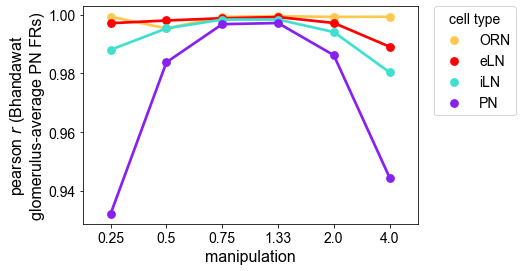

In [15]:
base_df_orn_frs_bhand_ON = d_full_res['base']['df_orn_frs_bhand_ON']
base_df_upn_frs_bhand_ON = d_full_res['base']['df_upn_frs_bhand_ON']
base_df_AL_activity_bhand = d_full_res['base']['df_AL_activity_bhand']

base_df_orn_glom_frs_bhand_ON, base_df_upn_glom_frs_bhand_ON = \
    make_glomerular_odor_responses(base_df_orn_frs_bhand_ON, base_df_upn_frs_bhand_ON, base_df_AL_activity_bhand)

flat_pn_base = base_df_upn_glom_frs_bhand_ON.values.flatten()

df_res_corr = []

plot_run_names = run_names_0p25 + run_names_0p5 + run_names_0p75

for ia in range(len(plot_run_names)):
    cur_run_name = plot_run_names[ia]
    
    df_orn_frs_bhand_ON = d_full_res[cur_run_name]['df_orn_frs_bhand_ON']
    df_upn_frs_bhand_ON = d_full_res[cur_run_name]['df_upn_frs_bhand_ON']
    df_AL_activity_bhand = d_full_res[cur_run_name]['df_AL_activity_bhand']
    
    df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON = \
        make_glomerular_odor_responses(df_orn_frs_bhand_ON, df_upn_frs_bhand_ON, df_AL_activity_bhand)
    
    flat_pn_run = df_upn_glom_frs_bhand_ON.values.flatten()
    r = np.corrcoef(flat_pn_base, flat_pn_run)[0, 1]
    
    df_res_corr += [list(cur_run_name.split(' '))+[r]]
    
df_res_corr = pd.DataFrame(df_res_corr, columns = ['cell type', 'manipulation', 'r'])
df_res_corr['manipulation2'] = df_res_corr['manipulation'].apply(lambda s: str2num(s))
df_res_corr

plt.figure(facecolor='white')
sns.pointplot(x='manipulation2', 
              y='r', 
              hue='cell type', 
              data=df_res_corr,
              palette=[d_color['ORN'],
                       d_color['eLN'],
                       d_color['iLN'],
                       d_color['PN']
                      ])
plt.ylabel(r'pearson $r$ (Bhandawat'+'\nglomerulus-average PN FRs)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='cell type')
plt.xlabel('manipulation')
plt.show()

In [16]:
mydenom = flat_pn_base.copy()
mydenom[mydenom == 0] = 1
mydiv = np.abs(flat_pn_run - flat_pn_base)/mydenom
mydiv[~np.isfinite(mydiv)] = np.nan
r = np.nanmean(mydiv)
mydiv, r

(array([ 1.2037037 ,  3.39285714,  1.36263736,  2.09677419,  2.26190476,
         1.94642857,  2.225     , 18.75      ,  0.976     ,  2.07142857,
         3.45454545,  0.81944444,  0.42990654,  0.27777778,  0.9516129 ,
         0.15972222,  7.5       ,  1.20408163,  0.82857143,  2.4       ,
         0.30327869,  1.1875    ,  0.60220994,  0.92366412,  1.06722689,
         0.69512195,  0.5257732 ,  1.2254902 , 86.25      ,  0.64534884,
         0.70807453,  0.4754902 ,  0.70121951,  1.21052632,  3.15789474,
         1.55172414,  0.87619048,  4.        ,  1.        ,  2.23076923,
         1.70454545,  3.66666667,  0.64341085,  1.25      ,  3.02777778,
         3.44186047,  1.0620155 ,  2.72340426,  1.8902439 ,  2.51351351,
         2.39583333,  2.15625   ,  3.27027027,  2.01369863,  2.08955224,
         2.5       ,  1.66666667,  1.8125    ,  2.5       ,  0.31147541,
         0.        ,  1.375     ,  0.        ,  0.        ,  1.77777778,
         2.5       ]),
 3.2112479151259015)

In [17]:
def calc_cohens_d(g1, g2):
    cohen_num = np.mean(g1) - np.mean(g2)
    cohen_denom = np.sqrt( 0.5 * (np.std(g1)**2 + np.std(g2)**2)  )
    cohen_d = cohen_num/cohen_denom
    return cohen_d

C:\Users\dB\Anaconda3\envs\ALVar\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\dB\Anaconda3\envs\ALVar\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\Users\dB\Anaconda3\envs\ALVar\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\dB\Anaconda3\envs\ALVar\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


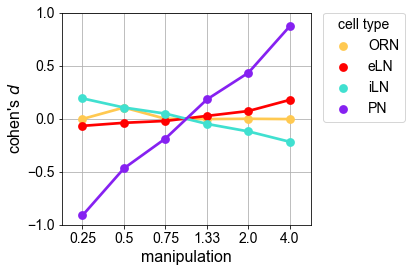

In [18]:
base_df_orn_frs_bhand_ON = d_full_res['base']['df_orn_frs_bhand_ON']
base_df_upn_frs_bhand_ON = d_full_res['base']['df_upn_frs_bhand_ON']
base_df_AL_activity_bhand = d_full_res['base']['df_AL_activity_bhand']

base_df_orn_glom_frs_bhand_ON, base_df_upn_glom_frs_bhand_ON = \
    make_glomerular_odor_responses(base_df_orn_frs_bhand_ON, base_df_upn_frs_bhand_ON, base_df_AL_activity_bhand)

flat_pn_base = base_df_upn_glom_frs_bhand_ON.values.flatten()

df_res_corr = []

plot_run_names = run_names_0p25 + run_names_0p5 + run_names_0p75

all_flats = [['base', 'x0']+list(flat_pn_base)]

df_metrics = [['base', 'x0',
               np.corrcoef(flat_pn_base, flat_pn_base)[0, 1],
               calc_cohens_d(flat_pn_base, flat_pn_base)]]

for ia in range(len(plot_run_names)):
    cur_run_name = plot_run_names[ia]
    
    df_orn_frs_bhand_ON = d_full_res[cur_run_name]['df_orn_frs_bhand_ON']
    df_upn_frs_bhand_ON = d_full_res[cur_run_name]['df_upn_frs_bhand_ON']
    df_AL_activity_bhand = d_full_res[cur_run_name]['df_AL_activity_bhand']
    
    df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON = \
        make_glomerular_odor_responses(df_orn_frs_bhand_ON, df_upn_frs_bhand_ON, df_AL_activity_bhand)
    
    flat_pn_run = df_upn_glom_frs_bhand_ON.values.flatten()
    
    mydiv = np.abs(flat_pn_run - flat_pn_base)/flat_pn_base
    mydiv[~np.isfinite(mydiv)] = np.nan
    r = np.nanmean(mydiv)
    
    mydenom = flat_pn_base.copy()
    mydenom[mydenom == 0] = 1
    mydiv = np.abs(flat_pn_run - flat_pn_base)/mydenom
    mydiv[~np.isfinite(mydiv)] = np.nan
    r = np.nanmean(mydiv)
    
    mydiv = np.abs(flat_pn_run - flat_pn_base)/400
    mydiv[~np.isfinite(mydiv)] = np.nan
    r = np.nanmean(mydiv)
    
    mydiv = np.abs(flat_pn_run - flat_pn_base)/flat_pn_base
    mydiv[np.isnan(mydiv)] = 0
    r = 100*np.nanmean(mydiv[np.isfinite(mydiv)])
    
    cohen_num = np.mean(flat_pn_run) - np.mean(flat_pn_base)
    cohen_denom = np.sqrt( 0.5 * (np.std(flat_pn_run)**2 + np.std(flat_pn_base)**2)  )
    cohen_d = cohen_num/cohen_denom
    r = cohen_d
    
    # compute similarity metrics
    pearson_r = np.corrcoef(flat_pn_base, flat_pn_run)[0, 1]
    cohens_d = calc_cohens_d(flat_pn_run, flat_pn_base)
    df_metrics.append(list(cur_run_name.split(' '))+[pearson_r, cohens_d])
    
    
    df_res_corr += [list(cur_run_name.split(' '))+[r]]
    
    all_flats.append(list(cur_run_name.split(' '))+list(flat_pn_run))
    
df_all_flats = pd.DataFrame(all_flats)
df_all_flats['run_name'] = ['base'] + plot_run_names
    
df_res_corr = pd.DataFrame(df_res_corr, columns = ['cell_type', 'manipulation', 'r'])
df_res_corr['manipulation2'] = df_res_corr['manipulation'].apply(lambda s: str2num(s))
df_res_corr

df_metrics = pd.DataFrame(df_metrics)
df_metrics.columns = ['cell_type', 'manipulation', 'pearson_r', 'cohens_d']
df_metrics['run_name'] = ['base'] + plot_run_names

fig, ax = plt.subplots(1,1,facecolor='white')

sns.pointplot(x='manipulation2', 
              y='r', 
              hue='cell_type', 
              data=df_res_corr,
              palette=[d_color['ORN'],
                       d_color['eLN'],
                       d_color['iLN'],
                       d_color['PN']
                      ]
             , zorder=100)
plt.ylabel(r"cohen's $d$")#+"\n((run mean - base mean)/pooled SD)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='cell type')
plt.xlabel('manipulation')
plt.ylim(-1,1)
plt.tight_layout()
plt.grid(zorder=-100)
ax.set_axisbelow(True)
#plt.savefig('single_param_cohen_d.png', dpi=400, bbox_inches='tight')
#plt.savefig('single_param_cohen_d.pdf', bbox_inches='tight')
plt.show()

In [19]:
odor_names = base_df_upn_glom_frs_bhand_ON.columns.values
glom_names = base_df_upn_glom_frs_bhand_ON.index.values

order_odors = np.tile(odor_names, 6)
order_gloms = np.repeat(glom_names, len(odor_names))
order_glom_odors = ['_'.join(x) for x in list(zip(order_gloms, order_odors))]

df_all_flats.columns = ['cell_type', 'manipulation'] + order_glom_odors + ['run_name']
df_all_flats['manipulation2'] = df_all_flats['manipulation'].apply(lambda s: str2num(s))

df_all_flats['cell_type'] = pd.Categorical(df_all_flats['cell_type'],
                                           categories=['base', 'ORN', 'eLN', 'iLN', 'PN'],
                                           ordered=True)

df_metrics['manipulation2'] = df_metrics['manipulation'].apply(lambda s: str2num(s))
df_metrics['cell_type'] = pd.Categorical(df_metrics['cell_type'],
                                           categories=['base', 'ORN', 'eLN', 'iLN', 'PN'],
                                           ordered=True)

df_all_flats = df_all_flats.sort_values(['cell_type', 'manipulation2'])
df_metrics = df_metrics.sort_values(['cell_type', 'manipulation2'])

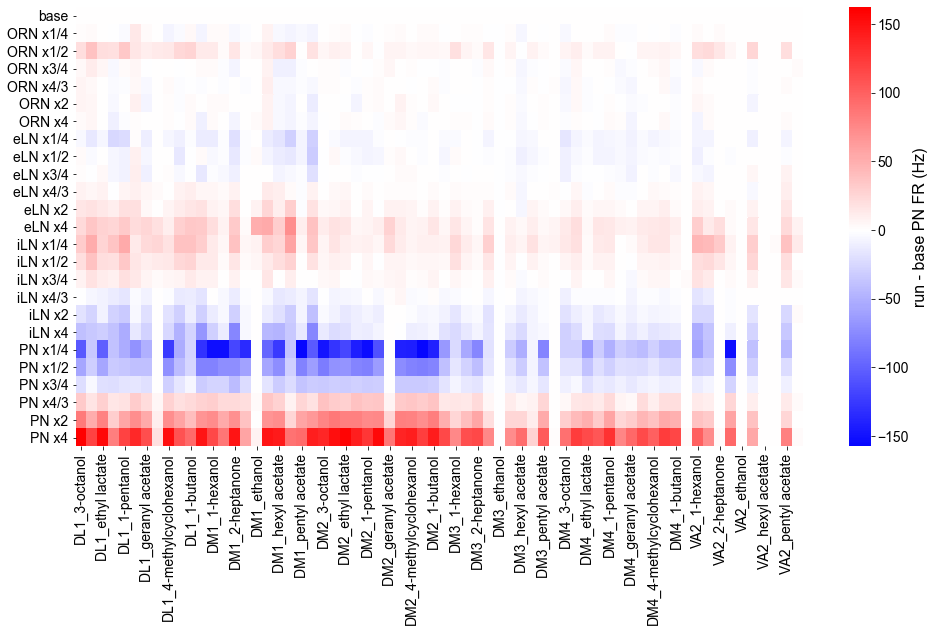

In [20]:
plot_df = df_all_flats.set_index('run_name')[order_glom_odors]
plot_df -= plot_df.loc['base']
#plot_df = (plot_df.T - plot_df.mean(1)).T

fig, axs = plt.subplots(1, 1, figsize=(14,9), facecolor='white')

sns.heatmap(plot_df, cmap='bwr', center=0, 
            cbar_kws={'label': 'run - base PN FR (Hz)'})

plt.ylabel('')
plt.tight_layout()
#plt.savefig('single_param_all_FRs_difference_with_base.png', dpi=400, bbox_inches='tight')
plt.show()

In [21]:
np.sum(flat_pn_base == 0) / len(flat_pn_base)

0.15151515151515152

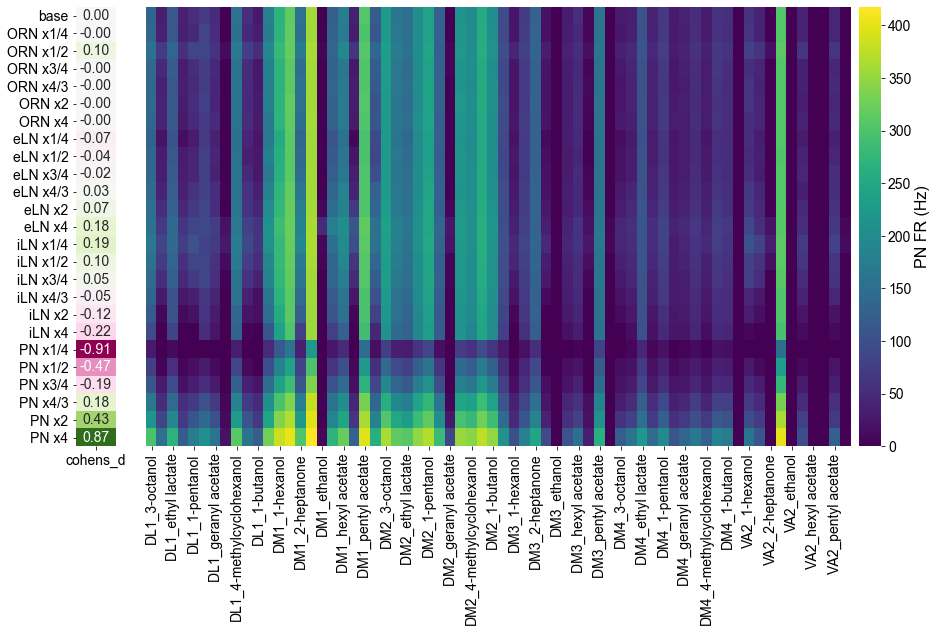

In [22]:
dfplot1 = pd.DataFrame(df_metrics.set_index('run_name')['cohens_d'])
dfplot2 = df_all_flats.set_index('run_name')[order_glom_odors]
#dfplot2 -= dfplot2.loc['base']
#dfplot2 = (dfplot2.T - dfplot2.mean(1)).T

fig, axs = plt.subplots(1, 2, figsize=(14,9), facecolor='white', gridspec_kw={'width_ratios': [1, 21]})

sns.heatmap(dfplot1, cmap='PiYG', center=0, ax=axs[0], 
            annot=True, fmt='0.2f', cbar=False)

sns.heatmap(dfplot2, cmap='viridis', center=None, ax=axs[1],
            cbar_kws={'label': 'PN FR (Hz)', 'pad': 0.01})


axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[1].set_yticks([])

plt.subplots_adjust(wspace=0.075)
plt.tight_layout()
#plt.savefig('single_param_all_FRs_with_cohen_d.png', dpi=400, bbox_inches='tight')
#plt.savefig('single_param_all_FRs_with_cohen_d.pdf', bbox_inches='tight')
plt.show()

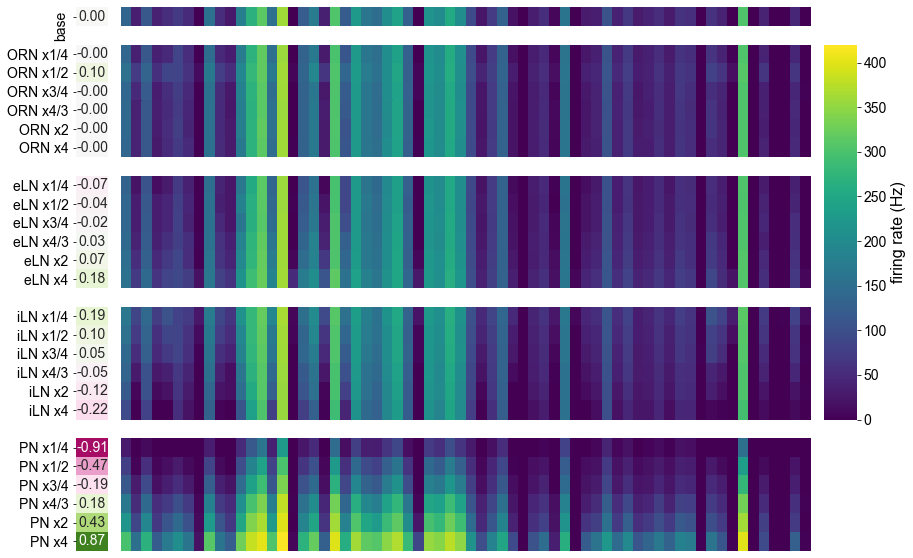

In [23]:
dfplot1 = pd.DataFrame(df_metrics.set_index('run_name')['cohens_d'])
dfplot2 = df_all_flats.set_index('run_name')[order_glom_odors]

dfplot1base = dfplot1[dfplot1.index.str.contains('base')]
dfplot1ORN = dfplot1[dfplot1.index.str.contains('ORN')]
dfplot1eLN = dfplot1[dfplot1.index.str.contains('eLN')]
dfplot1iLN = dfplot1[dfplot1.index.str.contains('iLN')]
dfplot1PN = dfplot1[dfplot1.index.str.contains('PN')]

dfplot2base = dfplot2[dfplot2.index.str.contains('base')]
dfplot2ORN = dfplot2[dfplot2.index.str.contains('ORN')]
dfplot2eLN = dfplot2[dfplot2.index.str.contains('eLN')]
dfplot2iLN = dfplot2[dfplot2.index.str.contains('iLN')]
dfplot2PN = dfplot2[dfplot2.index.str.contains('PN')]

#dfplot2 -= dfplot2.loc['base']
#dfplot2 = (dfplot2.T - dfplot2.mean(1)).T

fig = plt.figure(figsize=(14,10), facecolor='w')
gs = GridSpec(5, 3, figure=fig, width_ratios=[1, 21, 1], height_ratios=[1,6,6,6,6])


ax_base_cohen = fig.add_subplot(gs[0, 0])
ax_ORN_cohen = fig.add_subplot(gs[1, 0])
ax_eLN_cohen = fig.add_subplot(gs[2, 0])
ax_iLN_cohen = fig.add_subplot(gs[3, 0])
ax_PN_cohen = fig.add_subplot(gs[4, 0])

ax_base_frs = fig.add_subplot(gs[0, 1])#, sharey=ax_base_cohen)
ax_ORN_frs = fig.add_subplot(gs[1, 1])#, sharey=ax_ORN_cohen, sharex=ax_base_frs)
ax_eLN_frs = fig.add_subplot(gs[2, 1])#, sharey=ax_eLN_cohen, sharex=ax_base_frs)
ax_iLN_frs = fig.add_subplot(gs[3, 1])#, sharey=ax_iLN_cohen, sharex=ax_base_frs)
ax_PN_frs = fig.add_subplot(gs[4, 1])#, sharey=ax_PN_cohen, sharex=ax_base_frs)

cbar_ax = fig.add_subplot(gs[1:4, 2])

sns.heatmap(dfplot1base, cmap='PiYG', center=None, ax=ax_base_cohen,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(dfplot1ORN, cmap='PiYG', center=None, ax=ax_ORN_cohen, cbar_ax=cbar_ax,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(dfplot1eLN, cmap='PiYG', center=None, ax=ax_eLN_cohen, cbar_ax=cbar_ax,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(dfplot1iLN, cmap='PiYG', center=None, ax=ax_iLN_cohen, cbar_ax=cbar_ax,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(dfplot1PN, cmap='PiYG', center=None, ax=ax_PN_cohen, cbar_ax=cbar_ax,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)

sns.heatmap(dfplot2base, cmap='viridis', center=None, ax=ax_base_frs, cbar_ax=cbar_ax, vmin=0, vmax=420)
sns.heatmap(dfplot2ORN, cmap='viridis', center=None, ax=ax_ORN_frs, cbar_ax=cbar_ax, vmin=0, vmax=420)
sns.heatmap(dfplot2eLN, cmap='viridis', center=None, ax=ax_eLN_frs, cbar_ax=cbar_ax, vmin=0, vmax=420)
sns.heatmap(dfplot2iLN, cmap='viridis', center=None, ax=ax_iLN_frs, cbar_ax=cbar_ax, vmin=0, vmax=420)
sns.heatmap(dfplot2PN, cmap='viridis', center=None, ax=ax_PN_frs, cbar_ax=cbar_ax, vmin=0, vmax=420, 
            cbar_kws={'label': 'firing rate (Hz)'})
'''
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[1].set_yticks([])
'''

for ax in [ax_base_frs, ax_ORN_frs, ax_eLN_frs, ax_iLN_frs, ax_PN_frs]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('')

for ax in [ax_base_cohen, ax_ORN_cohen, ax_eLN_cohen, ax_iLN_cohen, ax_PN_cohen]:
    #ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
plt.subplots_adjust(wspace=0.05)
#plt.tight_layout()
#plt.savefig('single_param_all_FRs_with_cohen_d_expanded.png', dpi=400, bbox_inches='tight')
#plt.savefig('single_param_all_FRs_with_cohen_d_expanded.pdf', bbox_inches='tight')
plt.show()

In [24]:

def cos_sim(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))

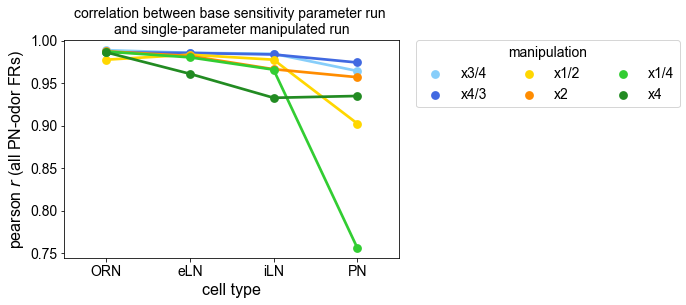

In [25]:
flat_all_pns_base = d_full_res['base']['df_upn_frs_allglom_ON'].values.flatten()

df_res_corr = []

plot_run_names = run_names_0p25 + run_names_0p5 + run_names_0p75

for ia in range(len(plot_run_names)):
    cur_run_name = plot_run_names[ia]
    
    flat_all_pns_run = d_full_res[cur_run_name]['df_upn_frs_allglom_ON'].values.flatten()
    r = np.corrcoef(flat_all_pns_base, flat_all_pns_run)[0, 1]
    r = spearmanr(flat_all_pns_base, flat_all_pns_run)[0]#[0, 1]
    
    df_res_corr += [list(cur_run_name.split(' '))+[r]]
    
df_res_corr = pd.DataFrame(df_res_corr, columns = ['cell type', 'manipulation', 'r'])
df_res_corr

plt.figure(facecolor='white')
sns.pointplot(x='cell type', 
              y='r', 
              hue='manipulation', 
              data=df_res_corr,
              palette=['lightskyblue', #3/4
                       'royalblue', #4/3
                       'gold', #x1/2
                       'darkorange', #x2
                       'limegreen',
                       'forestgreen'
                      ])
plt.ylabel(r'pearson $r$ (all PN-odor FRs)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), 
           borderaxespad=0, title='manipulation', ncol=3)
plt.title('correlation between base sensitivity parameter run \nand single-parameter manipulated run')
#plt.ylim(0.97, 1.001)
#plt.savefig('pearson_r_all_PN_odors.png', dpi=400, bbox_inches='tight')
#plt.savefig('pearson_r_all_PN_odors_zoom.png', dpi=400, bbox_inches='tight')
plt.show()

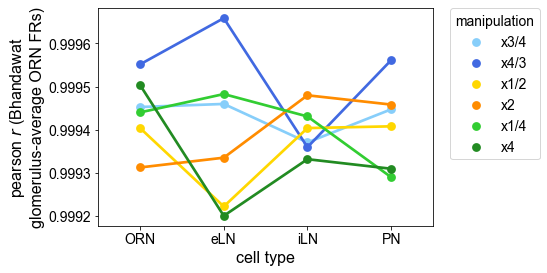

In [26]:
base_df_orn_frs_bhand_ON = d_full_res['base']['df_orn_frs_bhand_ON']
base_df_upn_frs_bhand_ON = d_full_res['base']['df_upn_frs_bhand_ON']
base_df_AL_activity_bhand = d_full_res['base']['df_AL_activity_bhand']

base_df_orn_glom_frs_bhand_ON, base_df_upn_glom_frs_bhand_ON = \
    make_glomerular_odor_responses(base_df_orn_frs_bhand_ON, base_df_upn_frs_bhand_ON, base_df_AL_activity_bhand)

flat_orn_base = base_df_orn_glom_frs_bhand_ON.values.flatten()

df_res_corr = []

plot_run_names = run_names_0p25 + run_names_0p5 + run_names_0p75

for ia in range(len(plot_run_names)):
    cur_run_name = plot_run_names[ia]
    
    df_orn_frs_bhand_ON = d_full_res[cur_run_name]['df_orn_frs_bhand_ON']
    df_upn_frs_bhand_ON = d_full_res[cur_run_name]['df_upn_frs_bhand_ON']
    df_AL_activity_bhand = d_full_res[cur_run_name]['df_AL_activity_bhand']
    
    df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON = \
        make_glomerular_odor_responses(df_orn_frs_bhand_ON, df_upn_frs_bhand_ON, df_AL_activity_bhand)
    
    flat_orn_run = df_orn_glom_frs_bhand_ON.values.flatten()
    r = np.corrcoef(flat_orn_base, flat_orn_run)[0, 1]
    
    df_res_corr += [list(cur_run_name.split(' '))+[r]]
    
df_res_corr = pd.DataFrame(df_res_corr, columns = ['cell type', 'manipulation', 'r'])
df_res_corr

plt.figure(facecolor='white')
sns.pointplot(x='cell type', 
              y='r', 
              hue='manipulation', 
              data=df_res_corr,
              palette=['lightskyblue', #3/4
                       'royalblue', #4/3
                       'gold', #x1/2
                       'darkorange', #x2
                       'limegreen',
                       'forestgreen'
                      ])
plt.ylabel(r'pearson $r$ (Bhandawat'+'\nglomerulus-average ORN FRs)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, title='manipulation')
plt.show()

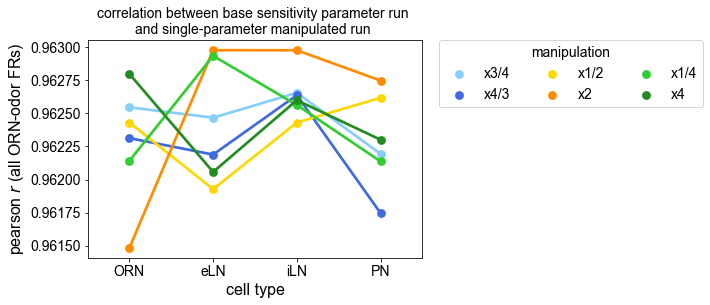

In [27]:
flat_all_orns_base = d_full_res['base']['df_orn_frs_allglom_ON'].values.flatten()

df_res_corr = []

plot_run_names = run_names_0p25 + run_names_0p5 + run_names_0p75

for ia in range(len(plot_run_names)):
    cur_run_name = plot_run_names[ia]
    
    flat_all_orns_run = d_full_res[cur_run_name]['df_orn_frs_allglom_ON'].values.flatten()
    r = np.corrcoef(flat_all_orns_base, flat_all_orns_run)[0, 1]
    
    df_res_corr += [list(cur_run_name.split(' '))+[r]]
    
df_res_corr = pd.DataFrame(df_res_corr, columns = ['cell type', 'manipulation', 'r'])
df_res_corr

plt.figure(facecolor='white')
sns.pointplot(x='cell type', 
              y='r', 
              hue='manipulation', 
              data=df_res_corr,
              palette=['lightskyblue', #3/4
                       'royalblue', #4/3
                       'gold', #x1/2
                       'darkorange', #x2
                       'limegreen',
                       'forestgreen'
                      ])
plt.ylabel(r'pearson $r$ (all ORN-odor FRs)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), 
           borderaxespad=0, title='manipulation', ncol=3)
plt.title('correlation between base sensitivity parameter run \nand single-parameter manipulated run ')
plt.show()

## multi-param manipulation

In [28]:
df_multi_scaling = [['base', 1, 0.4, 0.2, 4]]

df_multi_scaling += [[x,
  d_res_multi_0p5sd[x]['orn'], 
  d_res_multi_0p5sd[x]['eln'], 
  d_res_multi_0p5sd[x]['iln'], 
  d_res_multi_0p5sd[x]['pn']] for x in d_res_multi_0p5sd.keys()]

df_multi_scaling = pd.DataFrame(df_multi_scaling, columns=['run_name', 'orn', 'eln', 'iln', 'pn'])

df_multi_scaling['run_name2'] = df_multi_scaling['run_name']
df_multi_scaling.loc[1:, 'run_name2'] = ['multirun{}'.format(x) for x in np.arange(len(df_multi_scaling)-1)]
df_multi_scaling

,run_name,orn,eln,iln,pn,run_name2
0,base,1.000000,0.400000,0.200000,4.000000,base
1,0p5_2022_11_16-15_5_30,0.372330,0.073587,0.133114,4.104752,multirun0
2,0p5_2022_11_16-15_5_46,3.008670,0.233269,0.157551,3.084211,multirun1
3,0p5_2022_11_16-15_6_3,1.359825,0.209164,0.482204,4.899603,multirun2
4,0p5_2022_11_16-15_5_33,1.055057,1.044862,0.130940,2.417060,multirun3
5,0p5_2022_11_16-15_5_22,4.992970,0.572275,0.131736,5.031219,multirun4
6,0p5_2022_11_16-15_5_59,1.169532,0.471952,0.311336,3.770465,multirun5
7,0p5_2022_11_16-22_2_25,0.579578,0.855880,0.242336,1.599710,multirun6
8,0p5_2022_11_16-15_5_52,0.280473,0.751958,0.055920,4.848436,multirun7
9,0p5_2022_11_16-15_4_57,1.002384,0.383614,0.162431,4.398468,multirun8


In [29]:
plot_scale_df = df_multi_scaling.set_index('run_name2')[['orn', 'eln', 'iln', 'pn']]
plot_scale_df /= plot_scale_df.loc['base']

In [30]:
n_multi = len(run_names_multi)

In [31]:
base_df_orn_frs_bhand_ON = d_full_res['base']['df_orn_frs_bhand_ON']
base_df_upn_frs_bhand_ON = d_full_res['base']['df_upn_frs_bhand_ON']
base_df_AL_activity_bhand = d_full_res['base']['df_AL_activity_bhand']

base_df_orn_glom_frs_bhand_ON, base_df_upn_glom_frs_bhand_ON = \
    make_glomerular_odor_responses(base_df_orn_frs_bhand_ON, base_df_upn_frs_bhand_ON, base_df_AL_activity_bhand)

flat_pn_base = base_df_upn_glom_frs_bhand_ON.values.flatten()

plot_run_names = run_names_multi

df_metrics_multi = [[np.corrcoef(flat_pn_base, flat_pn_base)[0, 1],
                     calc_cohens_d(flat_pn_base, flat_pn_base)]]
all_flats_multi = [list(flat_pn_base)]

for ia in range(len(plot_run_names)):
    cur_run_name = plot_run_names[ia]
    
    df_orn_frs_bhand_ON = d_full_res[cur_run_name]['df_orn_frs_bhand_ON']
    df_upn_frs_bhand_ON = d_full_res[cur_run_name]['df_upn_frs_bhand_ON']
    df_AL_activity_bhand = d_full_res[cur_run_name]['df_AL_activity_bhand']
    
    df_orn_glom_frs_bhand_ON, df_upn_glom_frs_bhand_ON = \
        make_glomerular_odor_responses(df_orn_frs_bhand_ON, df_upn_frs_bhand_ON, df_AL_activity_bhand)
    
    flat_pn_run = df_upn_glom_frs_bhand_ON.values.flatten()
    all_flats_multi.append(list(flat_pn_run))
    
    # compute similarity metrics
    pearson_r = np.corrcoef(flat_pn_base, flat_pn_run)[0, 1]
    cohens_d = calc_cohens_d(flat_pn_run, flat_pn_base)
    df_metrics_multi.append([pearson_r, cohens_d])
    
df_all_flats_multi = pd.DataFrame(all_flats_multi)
df_all_flats_multi['run_name'] = ['base'] + plot_run_names
df_all_flats_multi.columns = order_glom_odors + ['run_name']

df_metrics_multi = pd.DataFrame(df_metrics_multi)
df_metrics_multi.columns = ['pearson_r', 'cohens_d']
df_metrics_multi['run_name'] = ['base'] + plot_run_names

### supplementary fig

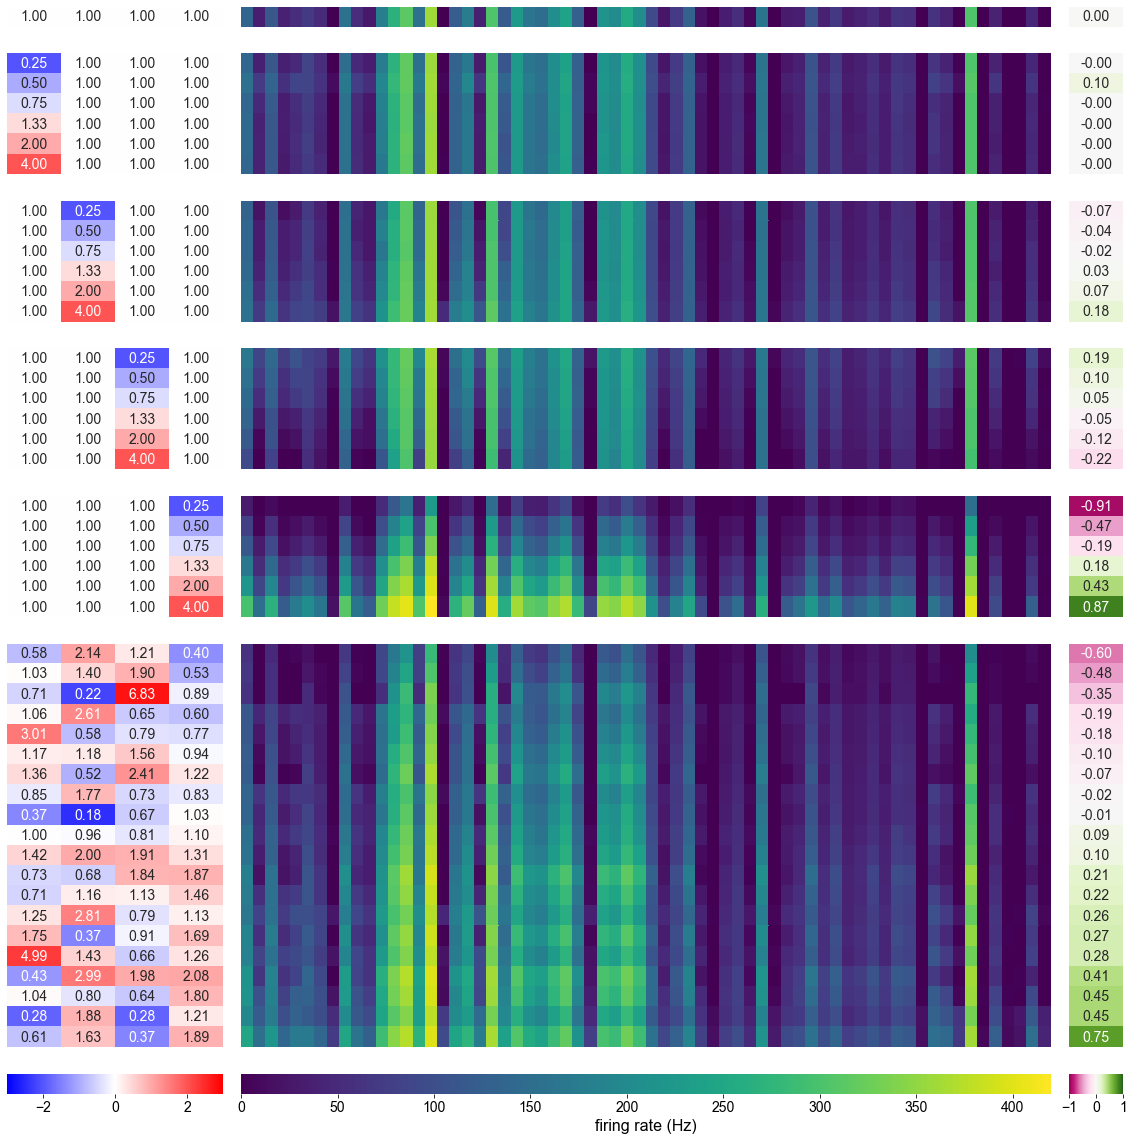

In [32]:
sort_col_order = df_metrics_multi.sort_values('cohens_d').index.values
sort_col_order = sort_col_order[sort_col_order != 0]

vals = [1/4, 1/2, 3/4, 4/3, 2, 4]
manips_array_base = pd.DataFrame(np.ones(4), index=['ORN', 'eLN', 'iLN', 'PN']).T
manips_array_ORN = pd.DataFrame(np.ones((4,6)), index=['ORN', 'eLN', 'iLN', 'PN']).T
manips_array_eLN = pd.DataFrame(np.ones((4,6)), index=['ORN', 'eLN', 'iLN', 'PN']).T
manips_array_iLN = pd.DataFrame(np.ones((4,6)), index=['ORN', 'eLN', 'iLN', 'PN']).T
manips_array_PN = pd.DataFrame(np.ones((4,6)), index=['ORN', 'eLN', 'iLN', 'PN']).T
manips_array_ORN.loc[:,'ORN'] = vals
manips_array_eLN.loc[:,'eLN'] = vals
manips_array_iLN.loc[:,'iLN'] = vals
manips_array_PN.loc[:,'PN'] = vals

dfplot1_single = pd.DataFrame(df_metrics.set_index('run_name')['cohens_d'])
dfplot2_single = df_all_flats.set_index('run_name')[order_glom_odors]
df_plot_multi_cohen = pd.DataFrame(df_metrics_multi.set_index('run_name').iloc[sort_col_order]['cohens_d'])
df_plot_multi_frs = df_all_flats_multi.set_index('run_name').iloc[sort_col_order]

df_plot_single_cohen_base = dfplot1_single[dfplot1_single.index.str.contains('base')]
df_plot_single_cohen_ORN = dfplot1_single[dfplot1_single.index.str.contains('ORN')]
df_plot_single_cohen_eLN = dfplot1_single[dfplot1_single.index.str.contains('eLN')]
df_plot_single_cohen_iLN = dfplot1_single[dfplot1_single.index.str.contains('iLN')]
df_plot_single_cohen_PN = dfplot1_single[dfplot1_single.index.str.contains('PN')]

df_plot_single_frs_base = dfplot2_single[dfplot2_single.index.str.contains('base')]
df_plot_single_frs_ORN = dfplot2_single[dfplot2_single.index.str.contains('ORN')]
df_plot_single_frs_eLN = dfplot2_single[dfplot2_single.index.str.contains('eLN')]
df_plot_single_frs_iLN = dfplot2_single[dfplot2_single.index.str.contains('iLN')]
df_plot_single_frs_PN = dfplot2_single[dfplot2_single.index.str.contains('PN')]


fig = plt.figure(figsize=(20,20), facecolor='w')
gs = GridSpec(7, 3, figure=fig, height_ratios=[1,6,6,6,6,20,1], width_ratios=[4, 15, 1])

ax_base_manips = fig.add_subplot(gs[0, 0])
ax_ORN_manips = fig.add_subplot(gs[1, 0])
ax_eLN_manips = fig.add_subplot(gs[2, 0])
ax_iLN_manips = fig.add_subplot(gs[3, 0])
ax_PN_manips = fig.add_subplot(gs[4, 0])
ax_multi_manips = fig.add_subplot(gs[5, 0])

ax_base_frs = fig.add_subplot(gs[0, 1])
ax_ORN_frs = fig.add_subplot(gs[1, 1])
ax_eLN_frs = fig.add_subplot(gs[2, 1])
ax_iLN_frs = fig.add_subplot(gs[3, 1])
ax_PN_frs = fig.add_subplot(gs[4, 1])
ax_multi_frs = fig.add_subplot(gs[5, 1])

ax_base_cohen = fig.add_subplot(gs[0, 2])
ax_ORN_cohen = fig.add_subplot(gs[1, 2])
ax_eLN_cohen = fig.add_subplot(gs[2, 2])
ax_iLN_cohen = fig.add_subplot(gs[3, 2])
ax_PN_cohen = fig.add_subplot(gs[4, 2])
ax_multi_cohen = fig.add_subplot(gs[5, 2])

ax_manips_cbar = fig.add_subplot(gs[6, 0])
ax_frs_cbar = fig.add_subplot(gs[6, 1])
ax_cohen_cbar = fig.add_subplot(gs[6, 2])

manips_min = -3
manips_max = 3
sns.heatmap(np.log2(manips_array_base), 
            cmap='bwr', center=0, ax=ax_base_manips,
            annot=manips_array_base, fmt='0.2f', 
            cbar=False, vmin=manips_min, vmax=manips_max)
sns.heatmap(np.log2(manips_array_ORN), 
            cmap='bwr', center=None, ax=ax_ORN_manips, cbar_ax=ax_manips_cbar,
            annot=manips_array_ORN, fmt='0.2f', 
            cbar=False, vmin=manips_min, vmax=manips_max)
sns.heatmap(np.log2(manips_array_eLN), 
            cmap='bwr', center=None, ax=ax_eLN_manips, cbar_ax=ax_manips_cbar,
            annot=manips_array_eLN, fmt='0.2f', 
            cbar=False, vmin=manips_min, vmax=manips_max)
sns.heatmap(np.log2(manips_array_iLN), 
            cmap='bwr', center=None, ax=ax_iLN_manips, cbar_ax=ax_manips_cbar,
            annot=manips_array_iLN, fmt='0.2f', 
            cbar=False, vmin=manips_min, vmax=manips_max)
sns.heatmap(np.log2(manips_array_PN), 
            cmap='bwr', center=None, ax=ax_PN_manips, cbar_ax=ax_manips_cbar,
            annot=manips_array_PN, fmt='0.2f', 
            cbar=False, vmin=manips_min, vmax=manips_max)
sns.heatmap(np.log2(plot_scale_df.iloc[sort_col_order]), 
            cmap='bwr', center=None, ax=ax_multi_manips, cbar_ax=ax_manips_cbar,
            annot=plot_scale_df.iloc[sort_col_order], fmt='0.2f', 
            cbar=True, vmin=manips_min, vmax=manips_max, cbar_kws={'orientation': 'horizontal'})

sns.heatmap(df_plot_single_frs_base, cmap='viridis', center=None, ax=ax_base_frs, cbar_ax=ax_frs_cbar, vmin=0, vmax=420)
sns.heatmap(df_plot_single_frs_ORN, cmap='viridis', center=None, ax=ax_ORN_frs, cbar_ax=ax_frs_cbar, vmin=0, vmax=420)
sns.heatmap(df_plot_single_frs_eLN, cmap='viridis', center=None, ax=ax_eLN_frs, cbar_ax=ax_frs_cbar, vmin=0, vmax=420)
sns.heatmap(df_plot_single_frs_iLN, cmap='viridis', center=None, ax=ax_iLN_frs, cbar_ax=ax_frs_cbar, vmin=0, vmax=420)
sns.heatmap(df_plot_single_frs_PN, cmap='viridis', center=None, ax=ax_PN_frs, cbar_ax=ax_frs_cbar, vmin=0, vmax=420)
sns.heatmap(df_plot_multi_frs, cmap='viridis', center=None, ax=ax_multi_frs, cbar_ax=ax_frs_cbar, vmin=0, vmax=420, 
            cbar_kws={'label': 'firing rate (Hz)', 'orientation': 'horizontal'})

sns.heatmap(df_plot_single_cohen_base, cmap='PiYG', center=None, ax=ax_base_cohen,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(df_plot_single_cohen_ORN, cmap='PiYG', center=None, ax=ax_ORN_cohen, cbar_ax=ax_cohen_cbar,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(df_plot_single_cohen_eLN, cmap='PiYG', center=None, ax=ax_eLN_cohen, cbar_ax=ax_cohen_cbar,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(df_plot_single_cohen_iLN, cmap='PiYG', center=None, ax=ax_iLN_cohen, cbar_ax=ax_cohen_cbar,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(df_plot_single_cohen_PN, cmap='PiYG', center=None, ax=ax_PN_cohen, cbar_ax=ax_cohen_cbar,
            annot=True, fmt='0.2f', cbar=False, vmin=-1, vmax=1)
sns.heatmap(df_plot_multi_cohen, cmap='PiYG', center=None, ax=ax_multi_cohen, cbar_ax=ax_cohen_cbar,
            annot=True, fmt='0.2f', cbar=True, vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal'})



for ax in [ax_base_manips, ax_ORN_manips, ax_eLN_manips, ax_iLN_manips, ax_PN_manips, ax_multi_manips]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in [ax_base_frs, ax_ORN_frs, ax_eLN_frs, ax_iLN_frs, ax_PN_frs, ax_multi_frs]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('')

for ax in [ax_base_cohen, ax_ORN_cohen, ax_eLN_cohen, ax_iLN_cohen, ax_PN_cohen, ax_multi_cohen]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
plt.subplots_adjust(wspace=0.05, hspace=0.2)
#plt.tight_layout()
#plt.savefig('single_param_all_FRs_with_cohen_d_expanded.png', dpi=400, bbox_inches='tight')
#plt.savefig('sup_fig_sensitivity_analysis.pdf', bbox_inches='tight')
plt.show()